In [24]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
from safetensors.torch import load_model

### Image Processing

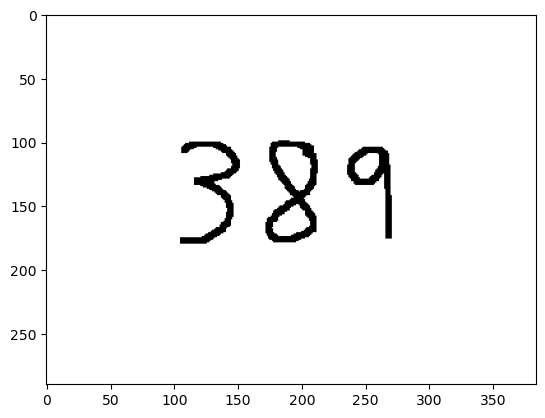

In [25]:
sample = cv2.imread("data/digits/389.png")
sample = cv2.cvtColor(sample, cv2.COLOR_BGR2GRAY)
_, thresh = cv2.threshold(sample, 125, 255, cv2.THRESH_BINARY_INV)
plt.imshow(sample, cmap="gray")

### Contouring

In [26]:
# dilation parameter; bigger tuple = smaller rectangle
rect_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (15, 1))

# apply dilation to the thresholded monochrome image
dilation = cv2.dilate(thresh, rect_kernel, iterations=1)

# find contours and rectangles
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

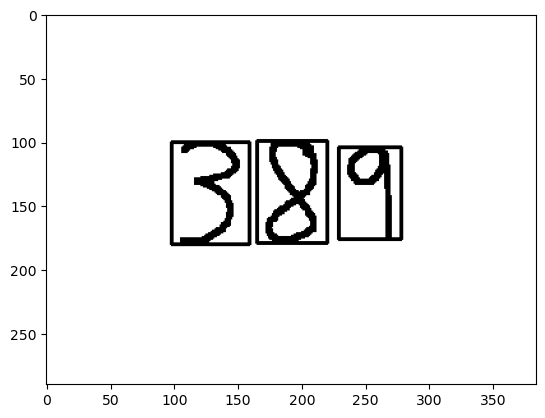

In [27]:
copy = sample.copy()

crops = []
for cnt in contours:
    # get coordinates of contours
    x, y, w, h = cv2.boundingRect(cnt)

    # draw rectangle for each contour
    cv2.rectangle(copy, (x, y), (x + w, y + h), (0, 255, 0), 2)

    # create crops per contour
    crop = thresh[y:y+h, x:x+w]
    crops.append(crop)

plt.imshow(copy, cmap="gray")

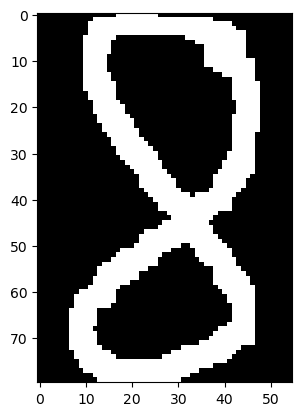

In [28]:
single = crops[2]
plt.imshow(single, cmap="gray")

### Resizing

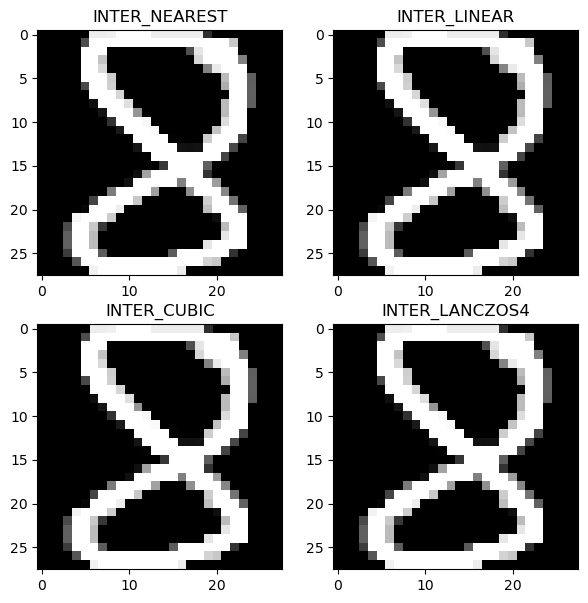

In [29]:
# see different interpolations of resizing crop
plt.figure(figsize=(7, 7))

plt.subplot(221);
nearest_resize = cv2.resize(single, (28, 28), cv2.INTER_NEAREST)
plt.title("INTER_NEAREST")
plt.imshow(nearest_resize, cmap="gray")

plt.subplot(222)
linear_resize = cv2.resize(single, (28, 28), cv2.INTER_LINEAR)
plt.title("INTER_LINEAR")
plt.imshow(linear_resize, cmap="gray")

plt.subplot(223)
cubic_resize = cv2.resize(single, (28, 28), cv2.INTER_CUBIC)
plt.title("INTER_CUBIC")
plt.imshow(cubic_resize, cmap="gray")

plt.subplot(224)
lanc_resize = cv2.resize(single, (28, 28), cv2.INTER_LANCZOS4)
plt.title("INTER_LANCZOS4")
plt.imshow(lanc_resize, cmap="gray")

About the same. Using default should be good already

### Model Insertion

In [30]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [31]:
class TinyVGG(nn.Module):

    def __init__(self):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(1, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(10, 10, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(10*7*7, 10+1) # 7 * 7 because maxpool has been done twice which divides the shape of image by 2 twice
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

model = TinyVGG().to(device)
load_model(model, "tinyvgg.safetensors")

(set(), [])

In [32]:
pic = torch.from_numpy(linear_resize).unsqueeze(dim=0).unsqueeze(dim=0).type(torch.float32).to(device)
pic.shape

torch.Size([1, 1, 28, 28])

In [33]:
model.eval()
with torch.inference_mode():
    results = model(pic)
    pred = results.argmax(dim=1)
    conf = torch.softmax(results, dim=1)[0][pred] * 100

print(f"Predicted Digit: {pred.item()}")

Predicted Digit: 8
